In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
import copy

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Preprocess

In [3]:
directory = './csvFiles'

In [4]:
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

In [5]:
# 파일 목록을 랜덤하게 섞습니다.
random.seed(42)  # 재현 가능한 결과를 위해 시드 설정
random.shuffle(csv_files)

In [6]:
# 첫 번째 파일에서 컬럼 이름을 가져옵니다.
first_file_path = os.path.join(directory, csv_files[0])
first_df = pd.read_csv(first_file_path)

In [7]:
separator_token = 999
separator = pd.DataFrame({col: separator_token for col in first_df.columns}, index=[0])

In [8]:
df_list = []
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    df = df.iloc[300:-100]
    df_list.append(df)
    df_list.append(separator) 

In [9]:
combined_df = pd.concat(df_list, ignore_index=True)

In [10]:
combined_df

,Frame,Time,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,...,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ,Unnamed: 128
0,301,3.454812,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.262754,352.2222,350.739100,0.733168,0.943708,0.631755,0.200809,359.55840,0.846429,NaN
1,302,3.465498,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.274371,352.2729,350.772300,0.733238,0.943977,0.631620,0.114945,359.53570,0.884086,NaN
2,303,3.476308,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.273871,352.2918,350.806000,0.733297,0.944234,0.631682,0.151095,359.52710,0.923961,NaN
3,304,3.487449,0.021056,0.537794,0.689871,358.82500,0.679492,359.8412,-0.037938,0.455332,...,8.267890,352.2754,350.814000,0.733297,0.944235,0.631826,0.239347,359.53850,0.959352,NaN
4,305,3.498579,0.021056,0.537794,0.689871,358.82500,0.679492,359.8412,-0.037938,0.455332,...,8.257694,352.2285,350.846900,0.733279,0.944438,0.631913,0.385812,359.57180,0.958712,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250495,4600,51.260610,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.131550,198.3722,3.791916,-1.323386,1.040075,0.924556,47.211770,37.32508,178.617100,NaN
1250496,4601,51.271360,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.133720,198.4202,3.836214,-1.323311,1.040272,0.924719,47.288450,37.23001,178.460700,NaN
1250497,4602,51.283000,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.135700,198.4699,3.866319,-1.323236,1.040406,0.924903,47.363370,37.13769,178.286900,NaN
1250498,4603,51.293670,-0.674747,0.459201,0.823021,18.44855,179.665600,357.4926,-0.614688,0.391303,...,11.140010,198.5145,3.896140,-1.322936,1.038698,0.926400,47.438840,37.06465,178.126200,NaN


In [11]:
len(combined_df)

1250500

In [12]:
# Rotation 컬럼만 선택
rotation_columns = [col for col in combined_df.columns if 'Rot' in col]

# Position 컬럼만 선택
position_columns = [col for col in combined_df.columns if 'Pos' in col]

# DataFrame 분리
rotation_df = combined_df[rotation_columns]
position_df = combined_df[position_columns]

# Rotation 컬럼만 -180~180 사이로 정규화
normalize_angle = lambda x:x if x == 999 else (x - 360) if x > 180 else (x + 360) if x < -180 else x
rotation_df = rotation_df.apply(lambda col: col.apply(normalize_angle))

# Position 컬럼만 0~1 사이로 정규화
def normalize_columns(df):
    for col in df.columns:
        if 'Pos' in col:  # 위치에 대한 컬럼만 정규화
            # 999 값을 제외하고 min 및 max를 계산
            filtered_df = df[df[col] != 999]
            min_val = filtered_df[col].min()
            max_val = filtered_df[col].max()

            # 999가 아닌 값만 정규화
            df.loc[df[col] != 999, col] = (df[col] - min_val) / (max_val - min_val)
    return df

position_df = normalize_columns(position_df)

C:\Users\admin\AppData\Local\Temp\ipykernel_30212\239680038.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col] != 999, col] = (df[col] - min_val) / (max_val - min_val)


In [13]:
# -180 ~ 180 범위를 벗어나는 값이 있는지 확인
num_values_out_of_range = rotation_df.apply(lambda col: col.apply(lambda x: x != 999 and (x > 180 or x < -180))).sum().sum()

# 결과 확인
if num_values_out_of_range > 0:
    print(f"범위를 벗어나는 값의 수: {num_values_out_of_range}")
else:
    print("범위를 벗어나는 값이 없습니다.")

범위를 벗어나는 값이 없습니다.


In [14]:
# 조인트 이름 추출
joint_names = [col.split('PosX')[0] for col in position_df.columns if 'PosX' in col]

# 빈 데이터 프레임 생성
posrot_df = pd.DataFrame()

# 각 조인트에 대해 위치 데이터와 회전 데이터를 순차적으로 배열
for joint in joint_names:
    posrot_df[f'{joint}PosX'] = position_df[f'{joint}PosX']
    posrot_df[f'{joint}PosY'] = position_df[f'{joint}PosY']
    posrot_df[f'{joint}PosZ'] = position_df[f'{joint}PosZ']
    posrot_df[f'{joint}RotX'] = rotation_df[f'{joint}RotX']
    posrot_df[f'{joint}RotY'] = rotation_df[f'{joint}RotY']
    posrot_df[f'{joint}RotZ'] = rotation_df[f'{joint}RotZ']

C:\Users\admin\AppData\Local\Temp\ipykernel_30212\3915166593.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  posrot_df[f'{joint}RotY'] = rotation_df[f'{joint}RotY']
C:\Users\admin\AppData\Local\Temp\ipykernel_30212\3915166593.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  posrot_df[f'{joint}RotZ'] = rotation_df[f'{joint}RotZ']
C:\Users\admin\AppData\Local\Temp\ipykernel_30212\3915166593.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

In [15]:
# Position 컬럼은 그대로 두고, 다시 합치기
posrot_df

,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,m_avg_L_HipPosZ,m_avg_L_HipRotX,...,m_avg_R_ElbowPosZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
0,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425514,8.262754,-7.7778,-9.260900,0.754464,0.705660,0.437026,0.200809,-0.44160,0.846429
1,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425524,8.274371,-7.7271,-9.227700,0.754483,0.705789,0.437009,0.114945,-0.46430,0.884086
2,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425540,8.273871,-7.7082,-9.194000,0.754499,0.705913,0.437017,0.151095,-0.47290,0.923961
3,0.586219,0.625759,0.428094,-1.17500,0.679492,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425547,8.267890,-7.7246,-9.186000,0.754499,0.705914,0.437034,0.239347,-0.46150,0.959352
4,0.586219,0.625759,0.428094,-1.17500,0.679492,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425527,8.257694,-7.7715,-9.153100,0.754494,0.706012,0.437045,0.385812,-0.42820,0.958712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250495,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.131550,-161.6278,3.791916,0.200521,0.752044,0.473122,47.211770,37.32508,178.617100
1250496,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.133720,-161.5798,3.836214,0.200541,0.752139,0.473142,47.288450,37.23001,178.460700
1250497,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.135700,-161.5301,3.866319,0.200561,0.752204,0.473165,47.363370,37.13769,178.286900
1250498,0.372510,0.563243,0.446288,18.44855,179.665600,-2.5074,0.383066,0.563565,0.453621,-0.7340,...,0.455199,11.140010,-161.4855,3.896140,0.200642,0.751381,0.473349,47.438840,37.06465,178.126200


# Transformer Learning

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [17]:
# 변환된 데이터를 DataFrame으로 변환
posrot_df = pd.DataFrame(posrot_df, columns=posrot_df.columns)

In [18]:
posrot_df

,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,m_avg_L_HipPosZ,m_avg_L_HipRotX,...,m_avg_R_ElbowPosZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
0,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425514,8.262754,-7.7778,-9.260900,0.754464,0.705660,0.437026,0.200809,-0.44160,0.846429
1,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425524,8.274371,-7.7271,-9.227700,0.754483,0.705789,0.437009,0.114945,-0.46430,0.884086
2,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425540,8.273871,-7.7082,-9.194000,0.754499,0.705913,0.437017,0.151095,-0.47290,0.923961
3,0.586219,0.625759,0.428094,-1.17500,0.679492,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425547,8.267890,-7.7246,-9.186000,0.754499,0.705914,0.437034,0.239347,-0.46150,0.959352
4,0.586219,0.625759,0.428094,-1.17500,0.679492,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425527,8.257694,-7.7715,-9.153100,0.754494,0.706012,0.437045,0.385812,-0.42820,0.958712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250495,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.131550,-161.6278,3.791916,0.200521,0.752044,0.473122,47.211770,37.32508,178.617100
1250496,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.133720,-161.5798,3.836214,0.200541,0.752139,0.473142,47.288450,37.23001,178.460700
1250497,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.135700,-161.5301,3.866319,0.200561,0.752204,0.473165,47.363370,37.13769,178.286900
1250498,0.372510,0.563243,0.446288,18.44855,179.665600,-2.5074,0.383066,0.563565,0.453621,-0.7340,...,0.455199,11.140010,-161.4855,3.896140,0.200642,0.751381,0.473349,47.438840,37.06465,178.126200


In [19]:
train = posrot_df.iloc[:1000400]
test = posrot_df.iloc[1000400:]

In [20]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=42, shuffle=False)

In [21]:
batch_size = 128
n_input = 30 # 시퀀스 수

In [22]:
class TimeseriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, index):
        x = self.data[index:index+self.sequence_length] # : 입력 시퀀스 (30개의 데이터)
        y = self.data[index+self.sequence_length-1] # : 예측 시퀀스 (1개의 데이터)
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

# 데이터셋과 데이터 로더를 생성
train_dataset = TimeseriesDataset(X_train.values, n_input)
val_dataset = TimeseriesDataset(X_val.values, n_input)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [23]:
# 데이터 로더에서 첫 번째 배치를 가져와서 형태를 확인
first_batch = next(iter(train_loader))
X, y = first_batch

print("X batch shape:", X.shape)
print("y batch shape:", y.shape)

X batch shape: torch.Size([128, 30, 126])
y batch shape: torch.Size([128, 126])


# GCN skeleton joint learning

In [24]:
joint_names = ['Pelvis', 'L_Hip', 'L_Knee', 'L_Ankle', 'L_Foot', 
                'R_Hip', 'R_Knee', 'R_Ankle', 'R_Foot', 'Spine1', 'Spine2',
               'L_Collar', 'L_Shoulder', 'L_Elbow', 'L_Wrist', 'Neck', 'Head',
               'R_Collar', 'R_Shoulder', 'R_Elbow', 'R_Wrist']
               

In [25]:
connections = [
    ('Pelvis', 'L_Hip'), ('Pelvis', 'R_Hip'),
    ('L_Hip', 'L_Knee'), ('R_Hip', 'R_Knee'),
    ('L_Knee', 'L_Ankle'), ('R_Knee', 'R_Ankle'),
    ('L_Ankle', 'L_Foot'), ('R_Ankle', 'R_Foot'),
    ('Spine1', 'Spine2'), ('Spine2', 'Pelvis'),
    ('Spine1', 'Neck'), ('Neck', 'Head'),
    ('Spine1', 'L_Collar'), ('Spine1', 'R_Collar'),
    ('L_Collar', 'L_Shoulder'), ('R_Collar', 'R_Shoulder'),
    ('L_Shoulder', 'L_Elbow'), ('R_Shoulder', 'R_Elbow'),
    ('L_Elbow', 'L_Wrist'), ('R_Elbow', 'R_Wrist')
]

In [26]:
# 조인트 이름을 인덱스로 매핑
joint_to_index = {joint: idx for idx, joint in enumerate(joint_names)}

# 연결 정보를 인덱스 쌍으로 변환
edge_pairs = [(joint_to_index[joint_from], joint_to_index[joint_to]) for joint_from, joint_to in connections]

# edge_index 생성
edge_index = torch.tensor(edge_pairs, dtype=torch.long).t().contiguous()

In [27]:
edge_index

tensor([[ 0,  0,  1,  5,  2,  6,  3,  7,  9, 10,  9, 15,  9,  9, 11, 17, 12, 18,
         13, 19],
        [ 1,  5,  2,  6,  3,  7,  4,  8, 10,  0, 15, 16, 11, 17, 12, 18, 13, 19,
         14, 20]])

In [28]:
# 사용 가능한 GPU 목록을 출력
available_gpus = torch.cuda.device_count()
print("Available GPUs:", available_gpus)

# 현재 장치를 출력 (GPU 사용 가능시 CUDA 장치, 그렇지 않으면 CPU)
current_device = torch.cuda.current_device() if torch.cuda.is_available() else 'CPU'
print("Current device:", torch.cuda.get_device_name(current_device) if torch.cuda.is_available() else current_device)

Available GPUs: 1
Current device: NVIDIA GeForce RTX 4090


In [29]:
# 하이퍼파라미터 설정
batch_size = 128
num_nodes = 21  # 노드 수 (신체 관절 수)
num_node_features = 6  # 각 노드의 특성 수 (위치 및 회전 정보)
num_classes = 126  # 출력 클래스 수 (전체 특성 수)
sequence_length = 30  # 시퀀스 길이
in_channels = 30
out_channels = 256

lr = 0.0001
patience = 10
min_delta = 0.001
epochs = 100

In [30]:
class TemporalLayer(nn.Module):
    """ 시간적 특성을 처리하기 위한 레이어 """
    def __init__(self, in_channels, out_channels):
        super(TemporalLayer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        print("TemporalLayer Initialized:")
        print(self)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes * num_node_features, sequence_length]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class GCNWithTemporal(nn.Module):
    """ 공간적 및 시간적 특성을 모두 고려하는 GCN 모델 """
    def __init__(self, num_node_features, num_classes, sequence_length, num_nodes):
        super(GCNWithTemporal, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.temporal_layer = TemporalLayer(num_nodes * 256, 256)
        self.out = nn.Linear(7680, num_classes) # [batch_size, 256 * 30] = [batch_size, 7680]
        print("GCNWithTemporal Initialized:")
        print(self)

    def forward(self, x, edge_index):
        # 입력 데이터의 형태 확인 (4차원으로 처리)
        # print("Original input shape to GCNWithTemporal:", x.shape) [128, 30, 21, 6])
        
        # x의 형태를 [batch_size, sequence_length, num_nodes, num_node_features]에서
        # [batch_size * sequence_length, num_nodes, num_node_features]로 변환
        batch_size, sequence_length, num_nodes, num_node_features = x.shape
        x = x.reshape(batch_size * sequence_length, num_nodes, num_node_features)

        # GCN 적용
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        # print("Shape after GCN layers in GCNWithTemporal:", x.shape) [3840, 21, 256])

        # 원래 형태로 복원 (배치 사이즈와 시퀀스 길이를 유지하며 차원 재구성)
        x = x.view(batch_size, sequence_length, -1)
        # print("Shape before TemporalLayer in GCNWithTemporal:", x.shape) [128, 30, 5376])
       
        # 시간 차원을 처리합니다.
        x = self.temporal_layer(x)
        # print("Shape after TemporalLayer in GCNWithTemporal:", x.shape) [128, 256, 30])

        # 최종 출력 차원을 확인
        x = x.reshape(x.size(0), -1)
        # print("Shape before final linear layer in GCNWithTemporal:", x.shape) [128, 7680])

        x = self.out(x)
        return x


In [31]:
# 모델, 손실 함수, 최적화 알고리즘 초기화
gcn_model = GCNWithTemporal(num_node_features, num_classes, sequence_length, num_nodes)
optimizer = optim.Adam(gcn_model.parameters(), lr=0.0001)
loss_function = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

TemporalLayer Initialized:
TemporalLayer(
  (conv1): Conv1d(5376, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
)
GCNWithTemporal Initialized:
GCNWithTemporal(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 128)
  (conv3): GCNConv(128, 256)
  (temporal_layer): TemporalLayer(
    (conv1): Conv1d(5376, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (out): Linear(in_features=7680, out_features=126, bias=True)
)


In [32]:
# 모델을 현재 장치로 이동합니다.
gcn_model.to(current_device)

GCNWithTemporal(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 128)
  (conv3): GCNConv(128, 256)
  (temporal_layer): TemporalLayer(
    (conv1): Conv1d(5376, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (out): Linear(in_features=7680, out_features=126, bias=True)
)

In [33]:
# 손실을 저장할 리스트 초기화
train_losses = []
val_losses = []

# 가장 좋은 손실 값 초기화
best_loss = float('inf')
early_stopping_counter = 0


In [34]:
# 학습 루프 함수
def train_loop(gcn_model, dataloader, optimizer, loss_function, device, edge_index, num_nodes, num_node_features, sequence_length):
    gcn_model.train()
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for data, target in progress_bar:
        # 데이터 형태와 edge_index 검증을 위한 출력
        # print("Original data shape:", data.shape)
        # print("Edge index shape:", edge_index.shape)
        # print("Edge index:", edge_index)

        # 데이터 차원 변경
        edge_index = edge_index.to(device)
        data, target = data.to(device), target.to(device)
        data = data.view(-1, num_nodes, num_node_features, sequence_length)  
        # print("View applied data shape:", data.shape)
        data = data.permute(0, 3, 1, 2)  
        # print("Permute applied data shape:", data.shape)
        target = target.view(-1, num_classes)

        # 데이터 형태 출력
        # print("Transformed data shape:", data.shape)
        
        optimizer.zero_grad()
        output = gcn_model(data, edge_index)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

# 검증 루프 함수
def val_loop(gcn_model, dataloader, loss_function, device, edge_index, num_nodes, num_node_features, sequence_length):
    gcn_model.eval()
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for data, target in progress_bar:
            edge_index = edge_index.to(device)
            data, target = data.to(device), target.to(device)
            data = data.view(-1, num_nodes, num_node_features, sequence_length)  
            data = data.permute(0, 3, 1, 2)  
            target = target.view(-1, num_classes)

            output = gcn_model(data, edge_index)
            loss = loss_function(output, target)

            total_loss += loss.item() * data.size(0)
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss

In [35]:
# Early Stopping 준비
best_loss = float('inf')
early_stopping_counter = 0

# 메인 학습 루프
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    # train_loop 함수 호출 시 sequence_length 추가
    avg_train_loss = train_loop(gcn_model, train_loader, optimizer, loss_function, current_device, edge_index, num_nodes, num_node_features, sequence_length)
    # val_loop 함수 호출 시 sequence_length 추가
    avg_val_loss = val_loop(gcn_model, val_loader, loss_function, current_device, edge_index, num_nodes, num_node_features, sequence_length)

    print(f'Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(gcn_model.state_dict())
        torch.save(gcn_model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# 최적 모델 가중치 로드
gcn_model.load_state_dict(torch.load('best_model.pth'))

Epoch 1/100


Training Loss: 715.9440377836244, Validation Loss: 817.335742368179
Epoch 2/100


Training Loss: 357.20652895590285, Validation Loss: 502.71787789267546
Epoch 3/100


Training Loss: 278.9751689594684, Validation Loss: 431.00315927647677
Epoch 4/100


Training Loss: 242.07406179579297, Validation Loss: 410.93592286020896
Epoch 5/100


Training Loss: 217.85849436608407, Validation Loss: 388.1225982813531
Epoch 6/100


Training Loss: 201.05172759954814, Validation Loss: 400.9586761938511
Epoch 7/100


Training Loss: 188.91452693492457, Validation Loss: 386.92799722362304
Epoch 8/100


Training Loss: 178.8890902444322, Validation Loss: 378.0759460365927
Epoch 9/100


Training Loss: 170.63632872270966, Validation Loss: 351.8209939212388
Epoch 10/100


Training Loss: 164.33290517144135, Validation Loss: 385.81663503016205
Epoch 11/100


Training Loss: 159.47867532227357, Validation Loss: 400.7667867072437
Epoch 12/100


Training Loss: 154.19442340572158, Validation Loss: 349.32876591276965
Epoch 13/100


Training Loss: 150.01891910606733, Validation Loss: 364.9558488328579
Epoch 14/100


Training Loss: 146.40691624877903, Validation Loss: 366.0155408289587
Epoch 15/100


Training Loss: 143.82127628001737, Validation Loss: 335.6931422257832
Epoch 16/100


Training Loss: 140.12984032738177, Validation Loss: 345.4780934520755
Epoch 17/100


Training Loss: 137.80440973147043, Validation Loss: 376.61390483762824
Epoch 18/100


Training Loss: 134.83544031478513, Validation Loss: 383.48103133755825
Epoch 19/100


Training Loss: 133.258629555625, Validation Loss: 366.5241945801989
Epoch 20/100


Training Loss: 131.3126437831481, Validation Loss: 356.8179919619765
Epoch 21/100


Training Loss: 129.08644227110906, Validation Loss: 289.58334876559604
Epoch 22/100


Training Loss: 126.76848076049538, Validation Loss: 337.96071303605913
Epoch 23/100


Training Loss: 125.22080178113043, Validation Loss: 320.35071855169366
Epoch 24/100


Training Loss: 123.1520020020574, Validation Loss: 321.7664495651265
Epoch 25/100


Training Loss: 122.08989389361787, Validation Loss: 300.4675555014355
Epoch 26/100


Training Loss: 120.28135404864675, Validation Loss: 323.10025272931625
Epoch 27/100


Training Loss: 118.75675747433412, Validation Loss: 296.0401055165015
Epoch 28/100


Training Loss: 117.22237492601629, Validation Loss: 293.6482528534813
Epoch 29/100


Training Loss: 113.35235082385816, Validation Loss: 290.5416431682236
Epoch 30/100


Training Loss: 111.86988175975489, Validation Loss: 288.33930777857944
Epoch 31/100


Training Loss: 110.59252068977634, Validation Loss: 290.67635969075445
Epoch 32/100


Training Loss: 109.8937016759641, Validation Loss: 288.8195075969129
Epoch 33/100


Training Loss: 109.23254678462699, Validation Loss: 293.2174083795278
Epoch 34/100


Training Loss: 108.44282469976002, Validation Loss: 291.22905566490215
Epoch 35/100


Training Loss: 107.86446553921601, Validation Loss: 292.6669775077106
Epoch 36/100


Training Loss: 107.4263184112894, Validation Loss: 292.75412709975024
Epoch 37/100


Training Loss: 107.958405917163, Validation Loss: 281.7318684473984
Epoch 38/100


Training Loss: 107.4097722665203, Validation Loss: 282.33331846021355
Epoch 39/100


Training Loss: 106.99358426560052, Validation Loss: 281.8776157273377
Epoch 40/100


Training Loss: 107.06917363405772, Validation Loss: 282.14519710224135
Epoch 41/100


Training Loss: 106.9199261337048, Validation Loss: 282.33062756100463
Epoch 42/100


Training Loss: 106.81819042690287, Validation Loss: 281.19425085970755
Epoch 43/100


Training Loss: 106.84939523494454, Validation Loss: 281.3119256798989
Epoch 44/100


Training Loss: 106.7462742736671, Validation Loss: 282.2319861557251
Epoch 45/100


Training Loss: 106.66925747804066, Validation Loss: 282.4936502907457
Epoch 46/100


Training Loss: 106.33652859819756, Validation Loss: 283.0020414813754
Epoch 47/100


Training Loss: 106.4683137216235, Validation Loss: 283.5235573022141
Epoch 48/100


Training Loss: 106.31699106107868, Validation Loss: 282.91866475293915
Epoch 49/100


Training Loss: 106.22441994622406, Validation Loss: 281.9281605291481
Epoch 50/100


Training Loss: 106.29370783227881, Validation Loss: 281.9653971589906
Epoch 51/100


Training Loss: 106.2728372354437, Validation Loss: 282.13926699973246
Epoch 52/100


Training Loss: 106.37762254096192, Validation Loss: 282.15647639216013
Early stopping


<All keys matched successfully>

### Transformer Model

In [36]:
batch_size = 128
n_input = 30  # Sequence length
n_features = 126  # Number of features
output_units = (21 * 6)  # Output shape
head_size = 256  # Size of attention head
num_heads = 7  # Number of attention heads
ff_dim = 512  # Hidden layer size in feed forward network inside transformer
num_blocks = 4  # Number of transformer blocks
mlp_units = [512, 256, 128]  # Size of the dense layers of the final classifier
dropout_rate = 0.3
pad_value = 0  # 패딩에 사용할 값

In [37]:
# GCN 모델의 출력을 저장할 리스트 초기화
gcn_outputs = []
targets_list = []

for data, target in train_loader:
    data = data.to(current_device)
    target = target.to(current_device)
    edge_index = edge_index.to(current_device)

    batch_size, seq_len, total_features = data.shape
    if total_features == num_nodes * num_node_features:
        data = data.view(batch_size, seq_len, num_node_features, num_nodes)
        data = data.permute(0, 1, 3, 2)

        try:
            gcn_output = gcn_model(data, edge_index)
            gcn_outputs.append(gcn_output.detach())
            targets_list.append(target)  # 해당 배치의 타겟 데이터 저장
        except RuntimeError as e:
            print(f"An error occurred: {e}")
            break

# GCN 모델의 출력 텐서들의 차원을 확인
for i, output in enumerate(gcn_outputs):
    print(f"Output {i} shape: {output.shape}")

# 모든 배치에 대한 GCN 모델의 출력을 하나의 텐서로 결합
gcn_outputs_tensor = torch.cat(gcn_outputs, dim=0)
print("Combined GCN outputs tensor shape:", gcn_outputs_tensor.shape)

# 시퀀스 분할 및 패딩 추가
transformer_inputs = []
for i in range(0, gcn_outputs_tensor.size(0), n_input):
    seq = gcn_outputs_tensor[i:i+n_input]  # n_input 길이의 시퀀스 추출
    if seq.size(0) < n_input:
        # 패딩이 필요한 경우
        padding = torch.full((n_input - seq.size(0), n_features), pad_value, device=seq.device)
        seq = torch.cat([seq, padding], dim=0)  # 시퀀스 끝에 패딩 추가
    transformer_inputs.append(seq.unsqueeze(0))  # 배치 차원 추가

# transformer_inputs 리스트를 하나의 텐서로 결합
transformer_inputs_tensor = torch.cat(transformer_inputs, dim=0)
print("Transformer inputs tensor shape:", transformer_inputs_tensor.shape)

Output 0 shape: torch.Size([128, 126])
Output 1 shape: torch.Size([128, 126])
Output 2 shape: torch.Size([128, 126])
Output 3 shape: torch.Size([128, 126])
Output 4 shape: torch.Size([128, 126])
Output 5 shape: torch.Size([128, 126])
Output 6 shape: torch.Size([128, 126])
Output 7 shape: torch.Size([128, 126])
Output 8 shape: torch.Size([128, 126])
Output 9 shape: torch.Size([128, 126])
Output 10 shape: torch.Size([128, 126])
Output 11 shape: torch.Size([128, 126])
Output 12 shape: torch.Size([128, 126])
Output 13 shape: torch.Size([128, 126])
Output 14 shape: torch.Size([128, 126])
Output 15 shape: torch.Size([128, 126])
Output 16 shape: torch.Size([128, 126])
Output 17 shape: torch.Size([128, 126])
Output 18 shape: torch.Size([128, 126])
Output 19 shape: torch.Size([128, 126])
Output 20 shape: torch.Size([128, 126])
Output 21 shape: torch.Size([128, 126])
Output 22 shape: torch.Size([128, 126])
Output 23 shape: torch.Size([128, 126])
Output 24 shape: torch.Size([128, 126])
Output 25 

In [38]:
targets_tensor = torch.cat(targets_list, dim=0)

# Custom Dataset class to handle inputs and targets together
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
# 데이터셋 인스턴스 생성
dataset = CustomDataset(transformer_inputs_tensor, targets_tensor)

# 데이터셋을 훈련 세트와 검증 세트로 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [39]:
# Positional Encoding 정의
class PositionalEncoding(nn.Module):
    def __init__(self, n_features, n_input):
        super(PositionalEncoding, self).__init__() # 상속받은 nn.Module 클래스의 __init__() 메서드 호출
        pe = torch.zeros(n_input, n_features) # 가장 큰 시퀀스 길이인 max_len을 기준으로 모두 0으로 채워진 크기가 (max_len, n_features)인 텐서 생성
        position = torch.arange(0, n_input, dtype=torch.float).unsqueeze(1) # position 텐서 생성

        # div_term을 계산하는 방식 수정
        div_term = torch.exp(torch.arange(0, n_features, 2).float() * (-math.log(10000.0) / n_features)) # div_term 계산
        
        # div_term의 길이를 n_features의 절반으로 조정
        div_term = div_term.repeat_interleave(2)[:n_features] # div_term 텐서 생성

        pe[:, 0::2] = torch.sin(position * div_term[0::2]) # 짝수 인덱스에는 sin 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term[1::2]) # 홀수 인덱스에는 cos 함수 적용
        pe = pe.unsqueeze(0) # pe = [bs, seq_len, n_feautres]
        self.register_buffer('pe', pe) # pe 텐서를 모델의 버퍼로 등록

    def forward(self, x):
        pe = self.pe[:, :x.size(1), :].to(x.device)
        # print(f"x.size(): {x.size()}, pe.size(): {pe.size()}")
        x = x + pe
        return x

# Transformer Block 정의
class TransformerBlock(nn.Module):
    def __init__(self, n_features, num_heads, ff_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(n_features, num_heads, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(n_features, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, n_features)
        )
        self.norm1 = nn.LayerNorm(n_features)
        self.norm2 = nn.LayerNorm(n_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attention_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attention_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x
    
# 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, n_features, num_heads, ff_dim, num_blocks, mlp_units, dropout, n_input):
        super(TransformerModel, self).__init__()
        self.pos_encoder = PositionalEncoding(n_features, n_input)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(n_features, num_heads, ff_dim, dropout) for _ in range(num_blocks)])
        
        self.layers = nn.Sequential()
        # 첫 번째 nn.Linear 층의 입력 차원을 n_features로 설정
        self.layers.add_module("dense_0", nn.Linear(n_features, mlp_units[0]))
        self.layers.add_module("relu_0", nn.ReLU())
        self.layers.add_module("dropout_0", nn.Dropout(dropout))
        self.layers.add_module("norm_0", nn.LayerNorm(mlp_units[0]))

        # 이후 층들에 대한 설정
        for i in range(1, len(mlp_units)):
            self.layers.add_module(f"dense_{i}", nn.Linear(mlp_units[i-1], mlp_units[i]))
            self.layers.add_module(f"relu_{i}", nn.ReLU())
            self.layers.add_module(f"dropout_{i}", nn.Dropout(dropout))
            self.layers.add_module(f"norm_{i}", nn.LayerNorm(mlp_units[i]))

        # 최종 출력 층
        self.out = nn.Linear(mlp_units[-1], n_features)

    def forward(self, x):
        x = self.pos_encoder(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = torch.mean(x, dim=1)
        x = self.layers(x)
        return self.out(x)

transformer_model = TransformerModel(n_features, num_heads, ff_dim, num_blocks, mlp_units, dropout_rate, n_input)


In [40]:
# Positional Encoding 적용
pos_encoder = PositionalEncoding(n_features=n_features, n_input=n_input)
# transformer_input_sequences = pos_encoder(transformer_input_sequences)

In [41]:
column_order = [
    'm_avg_PelvisPosX', 'm_avg_PelvisPosY', 'm_avg_PelvisPosZ',
    'm_avg_PelvisRotX', 'm_avg_PelvisRotY', 'm_avg_PelvisRotZ',

    'm_avg_L_HipPosX', 'm_avg_L_HipPosY', 'm_avg_L_HipPosZ',
    'm_avg_L_HipRotX', 'm_avg_L_HipRotY', 'm_avg_L_HipRotZ',

    'm_avg_L_KneePosX', 'm_avg_L_KneePosY', 'm_avg_L_KneePosZ',
    'm_avg_L_KneeRotX', 'm_avg_L_KneeRotY', 'm_avg_L_KneeRotZ',

    'm_avg_L_AnklePosX', 'm_avg_L_AnklePosY', 'm_avg_L_AnklePosZ',
    'm_avg_L_AnkleRotX', 'm_avg_L_AnkleRotY', 'm_avg_L_AnkleRotZ',

    'm_avg_L_FootPosX', 'm_avg_L_FootPosY', 'm_avg_L_FootPosZ',
    'm_avg_L_FootRotX', 'm_avg_L_FootRotY', 'm_avg_L_FootRotZ',

    'm_avg_R_HipPosX', 'm_avg_R_HipPosY', 'm_avg_R_HipPosZ',
    'm_avg_R_HipRotX', 'm_avg_R_HipRotY', 'm_avg_R_HipRotZ',

    'm_avg_R_KneePosX', 'm_avg_R_KneePosY', 'm_avg_R_KneePosZ',
    'm_avg_R_KneeRotX', 'm_avg_R_KneeRotY', 'm_avg_R_KneeRotZ',

    'm_avg_R_AnklePosX', 'm_avg_R_AnklePosY', 'm_avg_R_AnklePosZ',
    'm_avg_R_AnkleRotX', 'm_avg_R_AnkleRotY', 'm_avg_R_AnkleRotZ',

    'm_avg_R_FootPosX', 'm_avg_R_FootPosY', 'm_avg_R_FootPosZ',
    'm_avg_R_FootRotX', 'm_avg_R_FootRotY', 'm_avg_R_FootRotZ',

    'm_avg_Spine1PosX', 'm_avg_Spine1PosY', 'm_avg_Spine1PosZ',
    'm_avg_Spine1RotX', 'm_avg_Spine1RotY', 'm_avg_Spine1RotZ',

    'm_avg_Spine2PosX', 'm_avg_Spine2PosY', 'm_avg_Spine2PosZ',
    'm_avg_Spine2RotX', 'm_avg_Spine2RotY', 'm_avg_Spine2RotZ',

    'm_avg_L_CollarPosX', 'm_avg_L_CollarPosY', 'm_avg_L_CollarPosZ',
    'm_avg_L_CollarRotX', 'm_avg_L_CollarRotY', 'm_avg_L_CollarRotZ',

    'm_avg_L_ShoulderPosX', 'm_avg_L_ShoulderPosY', 'm_avg_L_ShoulderPosZ',
    'm_avg_L_ShoulderRotX', 'm_avg_L_ShoulderRotY', 'm_avg_L_ShoulderRotZ',

    'm_avg_L_ElbowPosX', 'm_avg_L_ElbowPosY', 'm_avg_L_ElbowPosZ',
    'm_avg_L_ElbowRotX', 'm_avg_L_ElbowRotY', 'm_avg_L_ElbowRotZ',

    'm_avg_L_WristPosX', 'm_avg_L_WristPosY', 'm_avg_L_WristPosZ',
    'm_avg_L_WristRotX', 'm_avg_L_WristRotY', 'm_avg_L_WristRotZ',

    'm_avg_NeckPosX', 'm_avg_NeckPosY', 'm_avg_NeckPosZ',
    'm_avg_NeckRotX', 'm_avg_NeckRotY', 'm_avg_NeckRotZ',

    'm_avg_HeadPosX', 'm_avg_HeadPosY', 'm_avg_HeadPosZ',
    'm_avg_HeadRotX', 'm_avg_HeadRotY', 'm_avg_HeadRotZ',

    'm_avg_R_CollarPosX', 'm_avg_R_CollarPosY', 'm_avg_R_CollarPosZ',
    'm_avg_R_CollarRotX', 'm_avg_R_CollarRotY', 'm_avg_R_CollarRotZ',

    'm_avg_R_ShoulderPosX', 'm_avg_R_ShoulderPosY', 'm_avg_R_ShoulderPosZ',
    'm_avg_R_ShoulderRotX', 'm_avg_R_ShoulderRotY', 'm_avg_R_ShoulderRotZ',

    'm_avg_R_ElbowPosX', 'm_avg_R_ElbowPosY', 'm_avg_R_ElbowPosZ',
    'm_avg_R_ElbowRotX', 'm_avg_R_ElbowRotY', 'm_avg_R_ElbowRotZ',
    
    'm_avg_R_WristPosX', 'm_avg_R_WristPosY', 'm_avg_R_WristPosZ',
    'm_avg_R_WristRotX', 'm_avg_R_WristRotY', 'm_avg_R_WristRotZ'
    ]

In [42]:
column_names = [
    'm_avg_HeadPosX', 'm_avg_HeadPosY', 'm_avg_HeadPosZ',
    'm_avg_L_WristPosX', 'm_avg_L_WristPosY', 'm_avg_L_WristPosZ',
    'm_avg_R_WristPosX', 'm_avg_R_WristPosY', 'm_avg_R_WristPosZ',
    'm_avg_L_FootPosX', 'm_avg_L_FootPosY', 'm_avg_L_FootPosZ',
    'm_avg_R_FootPosX', 'm_avg_R_FootPosY', 'm_avg_R_FootPosZ',
    'm_avg_HeadRotX', 'm_avg_HeadRotY', 'm_avg_HeadRotZ',
    'm_avg_L_WristRotX', 'm_avg_L_WristRotY', 'm_avg_L_WristRotZ',
    'm_avg_R_WristRotX', 'm_avg_R_WristRotY', 'm_avg_R_WristRotZ',
    'm_avg_L_FootRotX', 'm_avg_L_FootRotY', 'm_avg_L_FootRotZ',
    'm_avg_R_FootRotX', 'm_avg_R_FootRotY', 'm_avg_R_FootRotZ',
]

weighted_columns_indices = [column_order.index(name) for name in column_names]
print(weighted_columns_indices)

[96, 97, 98, 84, 85, 86, 120, 121, 122, 24, 25, 26, 48, 49, 50, 99, 100, 101, 87, 88, 89, 123, 124, 125, 27, 28, 29, 51, 52, 53]


In [43]:
class CustomLoss(nn.Module):
    def __init__(self, weighted_columns_indices, weight_for_weighted_columns, threshold, penalty_weight):
        super(CustomLoss, self).__init__()
        self.weighted_columns_indices = torch.tensor(weighted_columns_indices)
        self.weight_for_weighted_columns = weight_for_weighted_columns
        self.threshold = threshold  # 신체 움직임의 임계값
        self.penalty_weight = penalty_weight  # 비정상적 움직임에 대한 패널티 가중치

    def forward(self, y_true, y_pred):
        # 각 조인트의 6개 특성에 대한 손실을 계산하기 위해 y_true와 y_pred의 마지막 차원을 제거
        y_pred_values = y_pred[:, :]

        # MSE 계산
        mse = F.mse_loss(y_true[:, :], y_pred_values, reduction='none')
        mse = mse.mean(axis=-1)

        # 특정 joint에 대한 가중치 적용
        weighted_mse = y_pred[:, self.weighted_columns_indices]
        weighted_mse = (weighted_mse ** 2) * self.weight_for_weighted_columns
        mse += weighted_mse.mean(axis=-1)

        # 과도한 움직임에 대한 패널티 적용
        excessive_movement_penalty = (y_pred - y_true).abs() > self.threshold
        penalty = excessive_movement_penalty.type(torch.float32) * self.penalty_weight
        mse += penalty.mean(axis=-1)

        return mse.mean()  # 전체 배치에 대한 평균 손실 반환

# 가중치를 적용할 열 인덱스와 가중치 값
weighted_columns_indices = weighted_columns_indices
weight_for_weighted_columns = 2.0

# 임계값과 패널티 가중치 설정
threshold = 10.0  # 예시 임계값
penalty_weight = 0.8  # 예시 패널티 가중치

# CustomLoss 인스턴스 생성
custom_loss_instance = CustomLoss(
    weighted_columns_indices=weighted_columns_indices,
    weight_for_weighted_columns=weight_for_weighted_columns,
    threshold=threshold,
    penalty_weight=penalty_weight
)

In [44]:
# 최적화기와 손실 함수
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001)
criterion = custom_loss_instance

In [45]:
# 설정
epochs = 500
patience = 7  # Early Stopping patience
best_loss = np.inf
early_stopping_counter = 0

In [46]:
# Learning Rate Scheduler 설정
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

In [47]:
# 사용 가능한 GPU 목록을 출력
available_gpus = torch.cuda.device_count()
print("Available GPUs:", available_gpus)

# 현재 장치를 출력 (GPU 사용 가능시 CUDA 장치, 그렇지 않으면 CPU)
current_device = torch.cuda.current_device() if torch.cuda.is_available() else 'CPU'
print("Current device:", torch.cuda.get_device_name(current_device) if torch.cuda.is_available() else current_device)

Available GPUs: 1
Current device: NVIDIA GeForce RTX 4090


In [48]:
transformer_model = transformer_model.to(current_device)

In [49]:
summary(transformer_model, input_size=(n_input, n_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
PositionalEncoding-1              [-1, 30, 126]               0
MultiheadAttention-2  [[-1, 30, 126], [-1, 2, 2]]               0
           Dropout-3              [-1, 30, 126]               0
         LayerNorm-4              [-1, 30, 126]             252
            Linear-5              [-1, 30, 512]          65,024
              ReLU-6              [-1, 30, 512]               0
            Linear-7              [-1, 30, 126]          64,638
           Dropout-8              [-1, 30, 126]               0
         LayerNorm-9              [-1, 30, 126]             252
 TransformerBlock-10              [-1, 30, 126]               0
MultiheadAttention-11  [[-1, 30, 126], [-1, 2, 2]]               0
          Dropout-12              [-1, 30, 126]               0
        LayerNorm-13              [-1, 30, 126]             252
           Linear-14              

In [50]:
for epoch in range(epochs):
    transformer_model.train()
    total_train_loss = 0.0

    train_progress_bar = tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{epochs}', leave=False)
    for batch_inputs, batch_targets in train_progress_bar:
        batch_inputs = batch_inputs.to(current_device)
        batch_targets = batch_targets.to(current_device)

        optimizer.zero_grad()
        outputs = transformer_model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_inputs.size(0)

    avg_train_loss = total_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    transformer_model.eval()
    total_val_loss = 0.0
    val_progress_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{epochs}', leave=False)
    with torch.no_grad():
        for batch_inputs, batch_targets in val_progress_bar:
            batch_inputs = batch_inputs.to(current_device)
            batch_targets = batch_targets.to(current_device)

            outputs = transformer_model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            total_val_loss += loss.item() * batch_inputs.size(0)

    avg_val_loss = total_val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(transformer_model.state_dict())
        torch.save({'transformer_model': transformer_model.state_dict(), 'gcn_model': gcn_model.state_dict()}, 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

# 최고의 모델 가중치 로드
transformer_model.load_state_dict(best_model_wts)


Epoch 1/500 - Training Loss: 5082.1315, Validation Loss: 5134.9440


Epoch 2/500 - Training Loss: 5064.8968, Validation Loss: 5115.2584


Epoch 3/500 - Training Loss: 5048.8190, Validation Loss: 5097.0040


Epoch 4/500 - Training Loss: 5033.5535, Validation Loss: 5080.2452


Epoch 5/500 - Training Loss: 5019.1310, Validation Loss: 5064.7904


Epoch 6/500 - Training Loss: 5005.5333, Validation Loss: 5050.6018


Epoch 7/500 - Training Loss: 4992.8021, Validation Loss: 5037.5146


Epoch 8/500 - Training Loss: 4980.7487, Validation Loss: 5025.5307


Epoch 9/500 - Training Loss: 4969.5291, Validation Loss: 5014.5609


Epoch 10/500 - Training Loss: 4958.9451, Validation Loss: 5004.6536


Epoch 11/500 - Training Loss: 4949.3232, Validation Loss: 4995.8103


Epoch 12/500 - Training Loss: 4940.6165, Validation Loss: 4988.0695


Epoch 13/500 - Training Loss: 4932.4997, Validation Loss: 4981.4030


Epoch 14/500 - Training Loss: 4925.3142, Validation Loss: 4975.7317


Epoch 15/500 - Training Loss: 4918.9503, Validation Loss: 4971.1818


Epoch 16/500 - Training Loss: 4913.5197, Validation Loss: 4967.8346


Epoch 17/500 - Training Loss: 4908.8169, Validation Loss: 4964.4898


Epoch 18/500 - Training Loss: 4904.6516, Validation Loss: 4962.0836


Epoch 19/500 - Training Loss: 4901.4340, Validation Loss: 4960.2257


Epoch 20/500 - Training Loss: 4898.2001, Validation Loss: 4959.0664


Epoch 21/500 - Training Loss: 4895.5004, Validation Loss: 4958.8825


Epoch 22/500 - Training Loss: 4893.4786, Validation Loss: 4958.1949


Epoch 23/500 - Training Loss: 4891.5164, Validation Loss: 4957.0721


Epoch 24/500 - Training Loss: 4889.8329, Validation Loss: 4957.3378


Epoch 25/500 - Training Loss: 4888.5850, Validation Loss: 4954.1260


Epoch 26/500 - Training Loss: 4886.7806, Validation Loss: 4954.9314


Epoch 27/500 - Training Loss: 4885.2189, Validation Loss: 4954.0729


Epoch 28/500 - Training Loss: 4883.7789, Validation Loss: 4950.1397


Epoch 29/500 - Training Loss: 4882.5381, Validation Loss: 4949.2034


Epoch 30/500 - Training Loss: 4880.3849, Validation Loss: 4950.2541


Epoch 31/500 - Training Loss: 4878.8259, Validation Loss: 4946.4905


Epoch 32/500 - Training Loss: 4876.7361, Validation Loss: 4943.7262


Epoch 33/500 - Training Loss: 4874.5242, Validation Loss: 4942.2131


Epoch 34/500 - Training Loss: 4872.8166, Validation Loss: 4939.1973


Epoch 35/500 - Training Loss: 4869.6477, Validation Loss: 4934.7818


Epoch 36/500 - Training Loss: 4866.4489, Validation Loss: 4931.5628


Epoch 37/500 - Training Loss: 4864.4845, Validation Loss: 4931.0897


Epoch 38/500 - Training Loss: 4861.3513, Validation Loss: 4926.7329


Epoch 39/500 - Training Loss: 4857.4087, Validation Loss: 4922.2518


Epoch 40/500 - Training Loss: 4853.9434, Validation Loss: 4919.4805


Epoch 41/500 - Training Loss: 4850.7182, Validation Loss: 4915.4374


Epoch 42/500 - Training Loss: 4847.7702, Validation Loss: 4912.0027


Epoch 43/500 - Training Loss: 4844.3171, Validation Loss: 4911.2583


Epoch 44/500 - Training Loss: 4841.6534, Validation Loss: 4911.6578


Epoch 45/500 - Training Loss: 4838.4960, Validation Loss: 4908.2422


Epoch 46/500 - Training Loss: 4833.4313, Validation Loss: 4902.3791


Epoch 47/500 - Training Loss: 4831.8384, Validation Loss: 4897.2215


Epoch 48/500 - Training Loss: 4827.9291, Validation Loss: 4894.8306


Epoch 49/500 - Training Loss: 4823.2710, Validation Loss: 4893.1566


Epoch 50/500 - Training Loss: 4820.1780, Validation Loss: 4888.5701


Epoch 51/500 - Training Loss: 4815.5518, Validation Loss: 4889.6507


Epoch 52/500 - Training Loss: 4812.7226, Validation Loss: 4881.4471


Epoch 53/500 - Training Loss: 4809.0223, Validation Loss: 4881.4111


Epoch 54/500 - Training Loss: 4804.4305, Validation Loss: 4876.7449


Epoch 55/500 - Training Loss: 4801.9843, Validation Loss: 4878.7673


Epoch 56/500 - Training Loss: 4799.7973, Validation Loss: 4877.2220


Epoch 57/500 - Training Loss: 4794.6716, Validation Loss: 4874.7016


Epoch 58/500 - Training Loss: 4791.2934, Validation Loss: 4867.2002


Epoch 59/500 - Training Loss: 4787.5818, Validation Loss: 4868.4579


Epoch 60/500 - Training Loss: 4783.6105, Validation Loss: 4864.2611


Epoch 61/500 - Training Loss: 4780.7710, Validation Loss: 4865.0612


Epoch 62/500 - Training Loss: 4778.6784, Validation Loss: 4865.0566


Epoch 63/500 - Training Loss: 4773.9425, Validation Loss: 4853.5390


Epoch 64/500 - Training Loss: 4770.0073, Validation Loss: 4852.3977


Epoch 65/500 - Training Loss: 4765.6607, Validation Loss: 4861.5157


Epoch 66/500 - Training Loss: 4762.9952, Validation Loss: 4849.1126


Epoch 67/500 - Training Loss: 4759.0088, Validation Loss: 4847.3689


Epoch 68/500 - Training Loss: 4754.4748, Validation Loss: 4849.4406


Epoch 69/500 - Training Loss: 4752.5677, Validation Loss: 4846.6739


Epoch 70/500 - Training Loss: 4749.8374, Validation Loss: 4841.1600


Epoch 71/500 - Training Loss: 4742.7926, Validation Loss: 4836.7425


Epoch 72/500 - Training Loss: 4739.9437, Validation Loss: 4837.2739


Epoch 73/500 - Training Loss: 4736.7647, Validation Loss: 4837.3636


Epoch 74/500 - Training Loss: 4733.1611, Validation Loss: 4837.4053


Epoch 75/500 - Training Loss: 4729.8890, Validation Loss: 4829.2966


Epoch 76/500 - Training Loss: 4725.0035, Validation Loss: 4830.8070


Epoch 77/500 - Training Loss: 4722.5466, Validation Loss: 4825.9959


Epoch 78/500 - Training Loss: 4719.6296, Validation Loss: 4822.0447


Epoch 79/500 - Training Loss: 4717.9467, Validation Loss: 4822.7480


Epoch 80/500 - Training Loss: 4710.7656, Validation Loss: 4819.2747


Epoch 81/500 - Training Loss: 4708.1663, Validation Loss: 4822.6014


Epoch 82/500 - Training Loss: 4703.9910, Validation Loss: 4816.5613


Epoch 83/500 - Training Loss: 4701.0150, Validation Loss: 4818.4504


Epoch 84/500 - Training Loss: 4700.4367, Validation Loss: 4816.7323


Epoch 85/500 - Training Loss: 4694.7419, Validation Loss: 4811.5103


Epoch 86/500 - Training Loss: 4689.8250, Validation Loss: 4807.4323


Epoch 87/500 - Training Loss: 4686.3633, Validation Loss: 4812.6377


Epoch 88/500 - Training Loss: 4683.0959, Validation Loss: 4813.1182


Epoch 89/500 - Training Loss: 4681.8726, Validation Loss: 4814.7705


Epoch 90/500 - Training Loss: 4674.3272, Validation Loss: 4811.1727


Epoch 91/500 - Training Loss: 4671.7959, Validation Loss: 4807.9807


Epoch 92/500 - Training Loss: 4671.6134, Validation Loss: 4808.1075


Epoch 93/500 - Training Loss: 4664.3137, Validation Loss: 4798.7664


Epoch 94/500 - Training Loss: 4661.8811, Validation Loss: 4806.2871


Epoch 95/500 - Training Loss: 4659.5294, Validation Loss: 4802.2761


Epoch 96/500 - Training Loss: 4657.6521, Validation Loss: 4803.9468


Epoch 97/500 - Training Loss: 4650.2311, Validation Loss: 4804.0748


Epoch 98/500 - Training Loss: 4647.5274, Validation Loss: 4805.9632


Epoch 99/500 - Training Loss: 4647.9545, Validation Loss: 4800.1848


Epoch 100/500 - Training Loss: 4640.3070, Validation Loss: 4799.3655
Early stopping triggered


<All keys matched successfully>

In [51]:
torch.save(transformer_model.state_dict(), 'final_model_Transformer.pth')

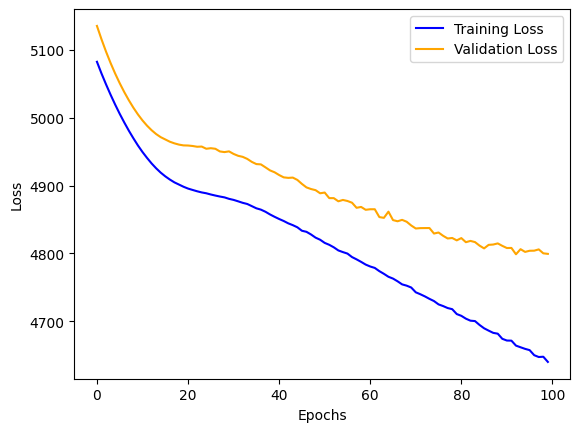

In [52]:
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test with Real Data

In [53]:
test_df = pd.read_csv('./B01_TransformData_FinalAvatar_20230922_171230.csv').iloc[300:-100]

In [54]:
test_df.head()

,Frame,Time,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,...,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ,Unnamed: 128
300,301,3.516298,0.167637,0.309281,1.707612,357.083,356.5699,359.1780,0.110527,0.229474,...,351.9312,358.1726,282.4885,0.484731,0.254242,1.712456,339.4850,296.8258,305.4126,NaN
301,302,3.527282,0.167637,0.309281,1.707612,357.083,356.5699,359.1780,0.110527,0.229474,...,350.7178,357.2758,281.4112,0.473791,0.253382,1.724783,337.8150,292.9910,307.2033,NaN
302,303,3.538654,0.167637,0.309281,1.707612,357.083,356.5699,359.1780,0.110527,0.229474,...,349.4878,356.3683,280.3726,0.462770,0.253029,1.736980,336.0336,289.2522,308.9090,NaN
303,304,3.549650,0.169145,0.316027,1.705714,357.288,355.9712,359.2451,0.112322,0.236200,...,348.2825,355.5042,279.3825,0.452501,0.258765,1.747534,334.1286,285.3405,310.8063,NaN
304,305,3.561161,0.169145,0.316027,1.705714,357.288,355.9712,359.2451,0.112322,0.236200,...,346.9774,354.4922,278.4650,0.441532,0.259532,1.759929,332.4753,281.4930,312.3235,NaN


In [55]:
test_rotation_columns = [col for col in test_df.columns if 'Rot' in col]

test_position_columns = [col for col in test_df.columns if 'Pos' in col]

# DataFrame 분리
test_rotation_df = test_df[test_rotation_columns]
test_position_df = test_df[test_position_columns]

# Rotation 컬럼만 -180~180 사이로 정규화
normalize_angle = lambda x:x if x == 999 else (x - 360) if x > 180 else (x + 360) if x < -180 else x
test_rotation_df = test_rotation_df.apply(lambda col: col.apply(normalize_angle))

# Position 컬럼만 0~1 사이로 정규화
def normalize_columns(df):
    for col in df.columns:
        if 'Pos' in col:  # 위치에 대한 컬럼만 정규화
            min_val = df[col].min()
            max_val = df[col].max()
            df[col] = (df[col] - min_val) / (max_val - min_val)
    return df

test_position_df = normalize_columns(test_position_df)

C:\Users\admin\AppData\Local\Temp\ipykernel_30212\1301280596.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - min_val) / (max_val - min_val)


In [56]:
# -180 ~ 180 범위를 벗어나는 값이 있는지 확인
num_values_out_of_range = test_rotation_df.apply(lambda col: col.apply(lambda x: x != 999 and (x > 180 or x < -180))).sum().sum()

# 결과 확인
if num_values_out_of_range > 0:
    print(f"범위를 벗어나는 값의 수: {num_values_out_of_range}")
else:
    print("범위를 벗어나는 값이 없습니다.")

범위를 벗어나는 값이 없습니다.


In [57]:
# 조인트 이름 추출
joint_names = [col.split('PosX')[0] for col in test_position_df.columns if 'PosX' in col]

# 빈 데이터 프레임 생성
test_posrot_df = pd.DataFrame()

# 각 조인트에 대해 위치 데이터와 회전 데이터를 순차적으로 배열
for joint in joint_names:
    test_posrot_df[f'{joint}PosX'] = test_position_df[f'{joint}PosX']
    test_posrot_df[f'{joint}PosY'] = test_position_df[f'{joint}PosY']
    test_posrot_df[f'{joint}PosZ'] = test_position_df[f'{joint}PosZ']
    test_posrot_df[f'{joint}RotX'] = test_rotation_df[f'{joint}RotX']
    test_posrot_df[f'{joint}RotY'] = test_rotation_df[f'{joint}RotY']
    test_posrot_df[f'{joint}RotZ'] = test_rotation_df[f'{joint}RotZ']

C:\Users\admin\AppData\Local\Temp\ipykernel_30212\619901990.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_posrot_df[f'{joint}RotY'] = test_rotation_df[f'{joint}RotY']
C:\Users\admin\AppData\Local\Temp\ipykernel_30212\619901990.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_posrot_df[f'{joint}RotZ'] = test_rotation_df[f'{joint}RotZ']
C:\Users\admin\AppData\Local\Temp\ipykernel_30212\619901990.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [58]:
test_posrot_df

,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,m_avg_L_HipPosZ,m_avg_L_HipRotX,...,m_avg_R_ElbowPosZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
300,0.680884,0.700545,0.176077,-2.917000,-3.4301,-0.8220,0.608099,0.673699,0.211484,3.120952,...,0.197403,-8.06880,-1.82740,-77.511500,0.729534,0.267148,0.294202,-20.5150,-63.1742,-54.58740
301,0.680884,0.700545,0.176077,-2.917000,-3.4301,-0.8220,0.608099,0.673699,0.211484,3.120952,...,0.205596,-9.28220,-2.72420,-78.588800,0.720036,0.265812,0.308725,-22.1850,-67.0090,-52.79670
302,0.680884,0.700545,0.176077,-2.917000,-3.4301,-0.8220,0.608099,0.673699,0.211484,3.120952,...,0.213703,-10.51220,-3.63170,-79.627400,0.710469,0.265263,0.323094,-23.9664,-70.7478,-51.09100
303,0.686855,0.742945,0.172705,-2.712000,-4.0288,-0.7549,0.614379,0.714597,0.207032,1.685574,...,0.219996,-11.71750,-4.49580,-80.617500,0.701554,0.274174,0.335528,-25.8714,-74.6595,-49.19370
304,0.686855,0.742945,0.172705,-2.712000,-4.0288,-0.7549,0.614379,0.714597,0.207032,1.685574,...,0.228235,-13.02260,-5.50780,-81.535000,0.692031,0.275365,0.350130,-27.5247,-78.5070,-47.67650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,0.519385,0.139780,0.930466,0.638496,-4.9859,-3.3039,0.456880,0.152755,0.883171,-2.606400,...,0.635778,10.26911,27.53492,2.730536,0.998555,0.969386,0.495864,-4.3464,-4.9749,20.78619
4672,0.519385,0.139780,0.930466,0.638496,-4.9859,-3.3039,0.456880,0.152755,0.883171,-2.606400,...,0.636200,10.29771,27.43369,2.622310,0.998918,0.967903,0.496610,-4.3793,-5.1034,20.48832
4673,0.519385,0.139780,0.930466,0.638496,-4.9859,-3.3039,0.456880,0.152755,0.883171,-2.606400,...,0.636689,10.31019,27.33001,2.567600,0.999292,0.967154,0.497477,-4.3998,-5.2624,20.17733
4674,0.519574,0.141442,0.930329,0.646919,-4.9892,-3.2873,0.457131,0.154270,0.883028,-2.453800,...,0.637043,10.33570,27.22439,2.487622,0.999716,0.965997,0.498215,-4.3402,-5.4903,19.92392


In [59]:
# 결과를 새로운 CSV 파일로 저장합니다.
test_posrot_df.to_csv('./test_posrot_df.csv', index=True)

In [60]:
# 모델 불러오기
model = TransformerModel(
    n_features=n_features,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_blocks=num_blocks,
    mlp_units=mlp_units,
    dropout=dropout_rate,
    n_input=n_input
)

model.load_state_dict(torch.load('final_model_Transformer.pth'))

# 모델을 평가 모드로 설정
model.eval()

# 예측 값을 넣을 빈 리스트
test_predictions = []

# 훈련 데이터셋에서 마지막 입력 개수의 값을 가져온 후
current_batch = torch.from_numpy(test_posrot_df[-n_input:].values.astype(np.float32)).reshape((1, n_input, n_features))

# 모델이 사용하는 디바이스를 확인하고 데이터를 해당 디바이스로 옮깁니다.
current_device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(current_device)
current_batch = current_batch.to(current_device)

# 예측 과정 반복
with torch.no_grad():  # 그래디언트 계산을 비활성화
    for i in range(1):
        # 현재 배치에서 다음 포인트를 예측
        current_pred = model(current_batch).cpu().numpy()[0]  # 마지막 시퀀스 포인트 예측

        # 예측된 마지막 프레임을 리스트에 추가
        test_predictions.append(current_pred)

        # 새로운 배치 생성: 마지막 시퀀스 제외하고 예측값 추가
        current_batch = np.roll(current_batch.cpu().numpy(), -1, axis=1)
        current_batch[:, -1, :] = current_pred
        current_batch = torch.from_numpy(current_batch).to(current_device)

In [61]:
test_predictions_array = np.array(test_predictions)

In [62]:
# 변환된 배열을 데이터프레임으로 변환합니다. 이때 column_order 리스트를 열 이름으로 사용합니다.
test_predictions = pd.DataFrame(test_predictions_array, columns=column_order)

# test_predictions 데이터프레임을 CSV 파일로 저장합니다.
test_predictions.to_csv('./test_predictions.csv', index=True)


In [63]:
test_predictions

,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,m_avg_L_HipPosZ,m_avg_L_HipRotX,...,m_avg_R_ElbowPosZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
0,0.353571,0.726626,0.523846,0.495838,-7.051992,-2.221874,0.425822,0.243101,0.333216,-15.737029,...,0.554312,-7.431786,-22.776726,-80.574921,0.726891,0.26719,0.081624,-25.383179,-36.594196,-60.065903


In [64]:
# input 데이터(test_df)의 마지막 30 프레임과 
last_inputs_df = test_posrot_df.iloc[-30:][column_order].reset_index(drop=True)
test_predictions_df = pd.DataFrame(test_predictions_array, columns=column_order)

test_combined_df = pd.concat([last_inputs_df, test_predictions_df], ignore_index=True)

In [65]:
test_combined_df

,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,m_avg_L_HipPosZ,m_avg_L_HipRotX,...,m_avg_R_ElbowPosZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
0,0.566909,0.268679,0.931187,1.290940,-2.860700,-1.524100,0.504530,0.267379,0.886133,-2.877000,...,0.603748,9.235965,30.738180,5.799457,0.987371,0.996524,0.455671,-1.586300,-1.084400,28.349760
1,0.401178,0.032587,0.952377,-10.836900,-133.453700,-3.480000,0.715442,0.037674,0.871273,-10.585300,...,0.831523,9.192002,30.799440,5.990096,0.670248,0.966425,0.654835,-1.953900,-1.223200,28.449170
2,0.401178,0.032587,0.952377,-10.836900,-133.453700,-3.480000,0.715442,0.037674,0.871273,-10.585300,...,0.831675,9.201011,30.785390,6.051675,0.670294,0.967268,0.655105,-2.252600,-1.385800,28.470040
3,0.401178,0.032587,0.952377,-10.836900,-133.453700,-3.480000,0.715442,0.037674,0.871273,-10.585300,...,0.831901,9.214252,30.751980,6.089844,0.670425,0.967791,0.655506,-2.550600,-1.553600,28.441560
4,0.520824,0.085088,0.924211,1.067918,-4.725700,-2.912200,0.459777,0.098134,0.877089,-1.369600,...,0.608386,9.240885,30.682460,6.062983,0.990379,0.966242,0.460271,-2.898700,-1.712400,28.449090
5,0.520824,0.085088,0.924211,1.067918,-4.725700,-2.912200,0.459777,0.098134,0.877089,-1.369600,...,0.608752,9.271243,30.603280,6.015287,0.990720,0.965589,0.460921,-3.255800,-1.870500,28.500560
6,0.520824,0.085088,0.924211,1.067918,-4.725700,-2.912200,0.459777,0.098134,0.877089,-1.369600,...,0.609138,9.311271,30.514670,5.937718,0.991109,0.964528,0.461604,-3.594500,-2.076100,28.504830
7,0.519916,0.132342,0.926505,0.828887,-4.648300,-3.010500,0.458313,0.144020,0.879789,-1.515400,...,0.624965,9.369996,30.333440,5.770970,0.991610,0.988035,0.476136,-3.908900,-2.329500,28.320140
8,0.519916,0.132342,0.926505,0.828887,-4.648300,-3.010500,0.458313,0.144020,0.879789,-1.515400,...,0.625572,9.437414,30.184760,5.606863,0.992260,0.985791,0.477211,-4.215200,-2.598400,27.988130
9,0.519916,0.132342,0.926505,0.828887,-4.648300,-3.010500,0.458313,0.144020,0.879789,-1.515400,...,0.626173,9.501136,30.033310,5.427882,0.992914,0.983341,0.478278,-4.474700,-2.938700,27.069070


In [66]:
test_combined_df.to_csv('./test_combined_df.csv', index=True)

# Visualize

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

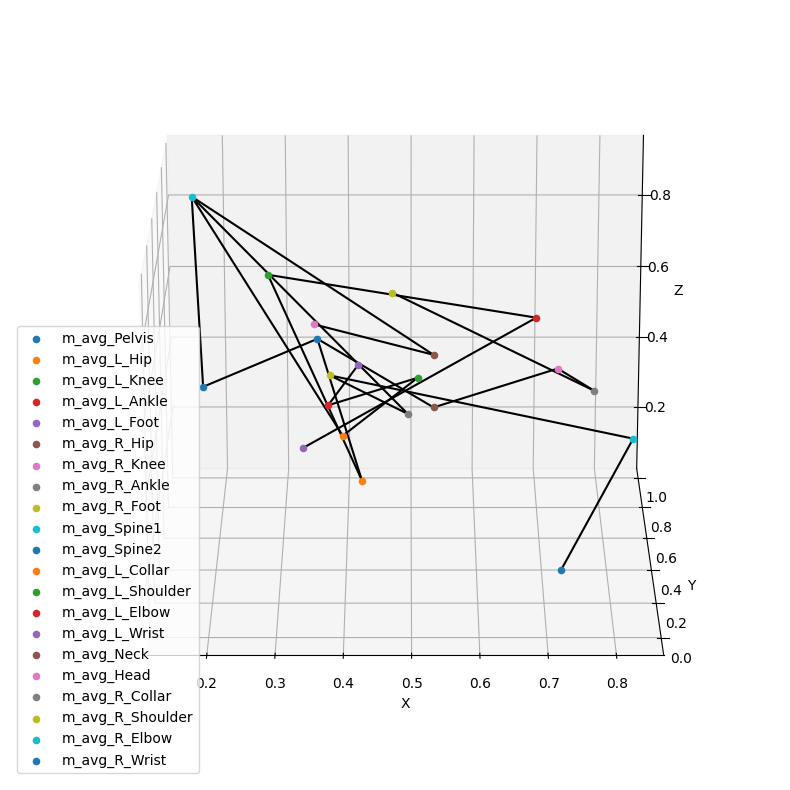

In [68]:
def visualize_skeleton(df, connections):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each joint
    for joint in joint_names:
        ax.scatter(df[f'{joint}PosX'], df[f'{joint}PosY'], df[f'{joint}PosZ'], label=joint)

    # Draw lines (bones) connecting the joints
    for connection in connections:
        joint_from, joint_to = connection
        # Update to use the correct column names
        ax.plot(
            [df[f'm_avg_{joint_from}PosX'], df[f'm_avg_{joint_to}PosX']],
            [df[f'm_avg_{joint_from}PosY'], df[f'm_avg_{joint_to}PosY']],
            [df[f'm_avg_{joint_from}PosZ'], df[f'm_avg_{joint_to}PosZ']],
            'k-'
        )

    # Set labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='best')

    # Set the initial viewing angle
    ax.view_init(elev=20., azim=-90)

    plt.show()

visualize_skeleton(test_predictions.iloc[0], connections)